# 【K-means】

In [1]:
import numpy as np
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

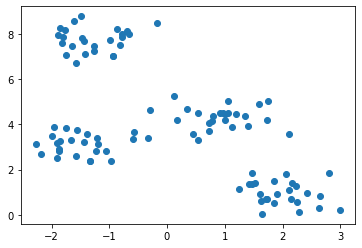

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])

In [3]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装
    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        
        self.min_sse = None
        self.min_centroids = None
        
        
        
    def init_centroids(self, X):
        """
        各データ点の中からランダムに各クラスタの初期値を選択する
        """
        n_data = X.shape[0]
        
        # random.permutation は重複なくサンプリングする(random.choiceだとダブる)
        # 指定したクラスタ数（self.n_clusters）分、重心の初期値を生成
        idx = np.random.permutation(n_data)[:self.n_clusters]
        centroids = X[idx]
        
        return centroids
    
    
    def compute_sse(self, X):
        """
        SSE（クラスタ内誤差平方和）を求める関数
        """
        new_cluster = np.zeros(X.shape[0])
        cluster = np.zeros(X.shape[0])
        distances = np.zeros((X.shape[0], self.n_clusters))
                
        # 重心（初期値）
        centroids = self.init_centroids(X)
        new_centroids = np.copy(centroids)
                
        # ↓ここから指定回数分（max_iter）、全データポイントと重心との差を出し、新しい重心に更新する処理を行う。
        
        # 距離を出し、
        for epoch in range(self.max_iter):
            for k in range(self.n_clusters):
                for j in range(X.shape[0]):
                    pq = X[j] - centroids[k]
                    distances[j][k] = np.linalg.norm(pq)

            # 新たな所属クラスタを割り当て、
            new_cluster = np.argmin(distances, axis=1)

            # 重心を更新する
            for new_k in range(self.n_clusters):
                new_centroids[new_k] = X[new_cluster == new_k].mean(axis=0)
                
            # sseを算出し、
            distance_min = np.min(distances, axis=1)
            sse = np.sum(distance_min)
            
            # 収束判定
            if sse <= self.tol:
                break

        return new_centroids, sse
        
        
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        
        # compute_sseメソッドを更に指定回数（self.n_init）実行し、その中からSSEが最小のものの重心を保存
        
        # 最小の重心の初期値をinfに設定し、
        self.min_sse = np.inf
        
        # sseが小さければ、最小値を更新して保存していく
        for i in range(self.n_init):
            new_centroids, sse = self.compute_sse(X)
            
            if sse <= self.min_sse:
                self.min_sse = sse
                self.min_centroids = new_centroids
                
            else:
                pass
            
            if self.verbose:
                print("iter{}のSSE : {}".format(i+1, sse))
                print("iter{}の重心 : {}".format(i+1, new_centroids))
                print("-----------------------------end of iter {} : -------------------------------".format(i+1))
        
        if self.verbose:
            print("【最小SSE】 : {}".format(self.min_sse))
            print("【最小SSEの重心】 : {}".format(self.min_centroids))
    
    
    
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        # 最小の重心
        centroids = self.min_centroids
        distances = np.zeros((X.shape[0], self.n_clusters))

        for k in range(self.n_clusters):
            for j in range(X.shape[0]):
                pq = X[j] - centroids[k]
                distances[j][k] = np.linalg.norm(pq)

        # 新たな所属クラスタ    
        new_cluster = np.argmin(distances, axis=1)
        
        return new_cluster

In [4]:
# インスタンス生成

skm = ScratchKMeans(n_clusters=4, n_init=5, max_iter=100, tol=50, verbose=False)

## 【問題1】中心点の初期値を決める

In [5]:
skm.init_centroids(X)

array([[-1.6609057 ,  3.31911046],
       [-1.44356727,  3.23539798],
       [-1.91186205,  3.18750686],
       [-0.33533163,  3.390122  ]])

## 【問題2】SSEを求める関数の作成

$$
SSE = \sum_{n=1}^{N} \sum_{k=1}^{K} r_{nk} ||X_n - \mu_k||^2
$$

* 各データ点$X_n$と、クラスタ数分の重心$\mu_k$とのユークリッド距離の累積和
  + ただし各データ点$X_n$と重心$\mu_k$が同じクラスタに所属していない場合の計算は無効
* SSEの中身は問題３~問題5で実装

##  【問題3】クラスタへの割り当て

* $\mu_k$ に「割り当てる」コード
* = 重心を求め、$X_i$について新たな所属クラスタを算出するコード

In [6]:
# ①重心の初期値

centroids = skm.init_centroids(X)
centroids

array([[-1.43284669,  7.71577043],
       [-2.18485772,  2.68708996],
       [ 0.5285368 ,  4.49723858],
       [ 1.85367905,  1.5088862 ]])

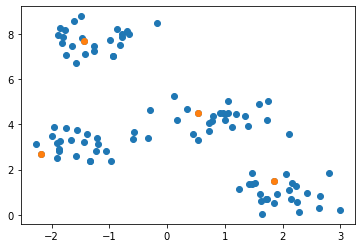

In [7]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1])

In [8]:
# ②新しいクラスタを格納する配列

new_cluster = np.zeros(X.shape[0])
new_cluster

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
# ③ 現在の各データ点の所属クラスタを格納する配列も別に作成

cluster = np.zeros(X.shape[0])
cluster

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
# ④ 現在の各データ点と重心の距離を計算する

# 各データ点の、重心との距離を格納する配列
distances = np.zeros((X.shape[0], skm.n_clusters))

# 全データに対して差の平方和をとる（行：サンプル数、列：クラスタ数）
for k in range(skm.n_clusters):
    
    for j in range(X.shape[0]):
        pq = X[j] - centroids[k]
        distances[j][k] = np.linalg.norm(pq)
    
    print(distances)

[[4.54498445 0.         0.         0.        ]
 [0.52669893 0.         0.         0.        ]
 [4.36030317 0.         0.         0.        ]
 [4.07065456 0.         0.         0.        ]
 [4.12876732 0.         0.         0.        ]
 [4.19573127 0.         0.         0.        ]
 [3.87850727 0.         0.         0.        ]
 [0.67926365 0.         0.         0.        ]
 [2.89103375 0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.85387814 0.         0.         0.        ]
 [0.72495713 0.         0.         0.        ]
 [0.49278384 0.         0.         0.        ]
 [0.44751633 0.         0.         0.        ]
 [0.64663732 0.         0.         0.        ]
 [8.70356297 0.         0.         0.        ]
 [6.52672858 0.         0.         0.        ]
 [4.46270922 0.         0.         0.        ]
 [4.80137673 0.         0.         0.        ]
 [8.47070315 0.         0.         0.        ]
 [5.44909063 0.         0.         0.        ]
 [0.40159343 

In [11]:
# ⑤-1 各データ点と重心との距離が出たので「割り当て」る = 各データ点に、最も距離の近いクラスタ番号を付与する
# ⑤-2 新しい所属クラスタとして②に格納

new_cluster = np.argmin(distances, axis=1)
new_cluster

array([2, 0, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 3, 3, 2, 1, 3, 2, 0,
       1, 3, 2, 1, 2, 2, 3, 3, 3, 0, 3, 3, 1, 2, 0, 3, 0, 1, 2, 1, 0, 1,
       1, 0, 3, 1, 2, 2, 2, 3, 1, 1, 1, 0, 0, 3, 3, 0, 0, 3, 3, 2, 3, 0,
       1, 1, 3, 2, 0, 3, 2, 0, 2, 2, 2, 1, 3, 3, 3, 0, 1, 2, 3, 1, 3, 3,
       2, 2, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2])

## 【問題4】中心点の移動

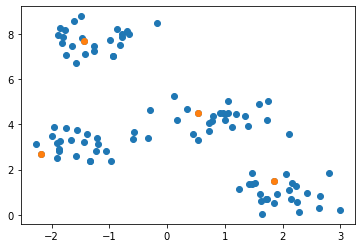

In [12]:
# もとの重心

plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1])

In [13]:
# 新たに重心を計算し「移動」= centroidsを更新する

new_centroids = np.copy(centroids)

for new_k in range(skm.n_clusters):
    new_centroids[new_k] = X[new_cluster == new_k].mean(axis=0)
    
print(new_centroids)

[[-1.26811733  7.76378266]
 [-1.61318321  3.06863899]
 [ 0.77324009  4.23350408]
 [ 1.99186903  0.96561071]]


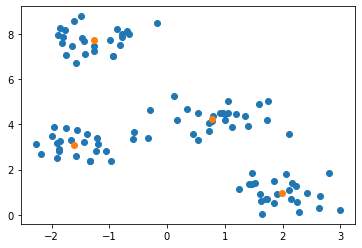

In [14]:
# 新しい重心

plt.scatter(X[:, 0], X[:, 1])
plt.scatter(new_centroids[:, 0], new_centroids[:, 1])

## 【問題5】繰り返し

* 繰り返し処理を含めてメソッドcompute_sse()に実装

In [15]:
skm_v2 = ScratchKMeans(n_clusters=4, n_init=30, max_iter=50, tol=50, verbose=True)

In [16]:
skm_v2.compute_sse(X)

(array([[-1.26811733,  7.76378266],
        [-1.47935679,  3.11716896],
        [ 1.99186903,  0.96561071],
        [ 0.92578447,  4.32475792]]),
 95.23187351962936)

## 【問題6】異なる初期値で計算

* 初期値を変更しながら、SSEが最小のものの中心点$\mu_k$を保持
  + 初期値はcompute_sse()内で実行ごとに変更される
  + SSEが前の計算結果より小さければコンストラクタに保存されるように、クラス内fit()メソッドとして実装

In [17]:
skm_v2.fit(X)

iter1のSSE : 139.7779329787627
iter1の重心 : [[ 1.57741049  3.00297183]
 [ 0.1741281   4.65939198]
 [-0.45858836  2.37279485]
 [-1.26811733  7.76378266]]
-----------------------------end of iter 1 : -------------------------------
iter2のSSE : 195.65805736673488
iter2の重心 : [[ 1.52979658  1.78487658]
 [-0.54329095  3.79336859]
 [-1.09398236  8.63697245]
 [-1.291863    7.64471132]]
-----------------------------end of iter 2 : -------------------------------
iter3のSSE : 199.56958683913385
iter3の重心 : [[-1.89783067  3.13723935]
 [-0.80780762  6.6808241 ]
 [-1.1934472   8.07957769]
 [ 0.93028832  2.61988336]]
-----------------------------end of iter 3 : -------------------------------
iter4のSSE : 154.550053864674
iter4の重心 : [[ 1.99186903  0.96561071]
 [-0.98111257  3.28451705]
 [-0.18552446  6.10000256]
 [-1.82285225  2.96491473]]
-----------------------------end of iter 4 : -------------------------------
iter5のSSE : 214.09764639403377
iter5の重心 : [[ 1.4329693   1.51128458]
 [-1.50151543  7.60452

## 【問題7】推定

* データ点$X_n$を最も近い$\mu_k$に割り当てる。
* 最小SSEの重心を使う

In [18]:
skm_v2.predict(X)

array([3, 1, 3, 3, 3, 3, 2, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 2, 2, 0, 3, 1,
       2, 0, 3, 2, 2, 3, 0, 0, 0, 1, 0, 0, 2, 3, 1, 0, 1, 2, 3, 2, 1, 2,
       2, 1, 0, 2, 3, 3, 3, 0, 2, 2, 2, 1, 1, 0, 0, 1, 1, 0, 0, 3, 0, 1,
       2, 2, 0, 3, 1, 0, 3, 1, 3, 3, 2, 2, 0, 0, 0, 1, 2, 3, 0, 2, 0, 0,
       3, 3, 3, 2, 3, 2, 2, 1, 1, 2, 1, 3])

## 【問題8】エルボー法の実装

* max_elbow数分、ScratchKMeans() の n_clusters を変えながら実行する
* 各イテレータごとに、self.min_sse の値を保存

In [19]:
max_elbow = 11
sse_list = []

for i in range(1, max_elbow):
    n_clusters = i
    skm = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=100, tol=50, verbose=True)
    skm.fit(X)
    sse_list.append(skm.min_sse)

iter1のSSE : 298.68370888061975
iter1の重心 : [[0.04254484 4.04283006]]
-----------------------------end of iter 1 : -------------------------------
iter2のSSE : 460.2009959061166
iter2の重心 : [[0.04254484 4.04283006]]
-----------------------------end of iter 2 : -------------------------------
iter3のSSE : 367.34094475465247
iter3の重心 : [[0.04254484 4.04283006]]
-----------------------------end of iter 3 : -------------------------------
iter4のSSE : 299.5897352321611
iter4の重心 : [[0.04254484 4.04283006]]
-----------------------------end of iter 4 : -------------------------------
iter5のSSE : 363.52866021518804
iter5の重心 : [[0.04254484 4.04283006]]
-----------------------------end of iter 5 : -------------------------------
iter6のSSE : 279.3826199491799
iter6の重心 : [[0.04254484 4.04283006]]
-----------------------------end of iter 6 : -------------------------------
iter7のSSE : 291.15898644685194
iter7の重心 : [[0.04254484 4.04283006]]
-----------------------------end of iter 7 : --------------------

iter3のSSE : 68.76784576486935
iter3の重心 : [[-1.56883283  3.08178097]
 [ 1.07851385  4.43351477]
 [ 0.09622429  3.78527345]
 [ 1.99186903  0.96561071]
 [-1.26811733  7.76378266]]
-----------------------------end of iter 3 : -------------------------------
iter4のSSE : 160.03494127879372
iter4の重心 : [[-1.64312637  7.20841048]
 [-1.12129992  3.73867153]
 [-0.89267726  7.69079018]
 [-1.59689678  8.22037898]
 [ 1.10193918  2.4384507 ]]
-----------------------------end of iter 4 : -------------------------------
iter5のSSE : 162.97560934599065
iter5の重心 : [[-1.3640238   8.24298477]
 [-1.20417968  7.44431458]
 [-0.99981703  2.2948813 ]
 [-1.26986839  3.56488694]
 [ 1.49419197  2.73601746]]
-----------------------------end of iter 5 : -------------------------------
iter6のSSE : 226.25062303164714
iter6の重心 : [[-0.65717281  8.13033646]
 [-0.35475667  3.89472806]
 [-1.48351899  8.06996463]
 [-1.56804942  7.3276816 ]
 [ 1.8384523   1.19314921]]
-----------------------------end of iter 6 : -------------

iter1のSSE : 68.18326683501508
iter1の重心 : [[-1.26811733  7.76378266]
 [-1.67365833  3.1145882 ]
 [ 1.21937212  4.57888355]
 [ 0.1741281   4.65939198]
 [-0.8699962   2.8630661 ]
 [ 0.57834643  3.58889204]
 [ 0.97792204  4.09507159]
 [ 1.99186903  0.96561071]]
-----------------------------end of iter 1 : -------------------------------
iter2のSSE : 55.19752952256809
iter2の重心 : [[ 2.35932244  1.03388401]
 [-1.52254194  7.50971468]
 [ 1.08588932  4.03132988]
 [-1.47935679  3.11716896]
 [-0.88648041  8.14488462]
 [ 0.49095131  4.48954094]
 [ 1.12637549  5.06338577]
 [ 1.65268127  0.9025892 ]]
-----------------------------end of iter 2 : -------------------------------
iter3のSSE : 80.33819970263836
iter3の重心 : [[-0.71868685  8.0052066 ]
 [ 2.13330325  1.16087323]
 [-1.61318321  3.06863899]
 [ 1.58985216  0.8204453 ]
 [-1.685415    8.46027303]
 [ 2.81090537  0.25201744]
 [ 0.77324009  4.23350408]
 [-1.4778291   7.40090934]]
-----------------------------end of iter 3 : ---------------------------

iter3のSSE : 55.13178237588784
iter3の重心 : [[-1.8965085   3.50679382]
 [-1.73946528  8.27860336]
 [ 1.68579491  4.71488405]
 [ 0.87189093  4.15640338]
 [-1.31713113  2.96564818]
 [-1.1192706   7.6012077 ]
 [ 2.31910566  0.46821372]
 [ 2.16066582  1.40091878]
 [ 1.53334601  1.12443476]
 [ 0.50709975  5.0008772 ]]
-----------------------------end of iter 3 : -------------------------------
iter4のSSE : 55.888692228751864
iter4の重心 : [[-1.20417968  7.44431458]
 [ 2.68710433  0.66454683]
 [ 0.09622429  3.78527345]
 [ 1.26888001  4.45802586]
 [-1.3640238   8.24298477]
 [ 1.84969568  1.45768569]
 [ 1.94443275  0.55564406]
 [ 2.11114739  3.57660449]
 [ 0.60465278  4.51391152]
 [-1.56883283  3.08178097]]
-----------------------------end of iter 4 : -------------------------------
iter5のSSE : 55.50057739457466
iter5の重心 : [[ 1.4242966   1.4307715 ]
 [ 1.25027307  4.52109551]
 [ 0.50428693  4.05652526]
 [-1.214539    2.93911402]
 [-1.89632556  3.30278361]
 [-0.80519631  8.0935421 ]
 [ 2.14051275  0.5

In [20]:
print(sse_list)

[268.51466678411526, 185.11204527649775, 145.10181973613447, 100.91455135629357, 62.594249760773316, 58.145403089562, 59.76473969654795, 55.19752952256809, 49.9885780543755, 55.13178237588784]


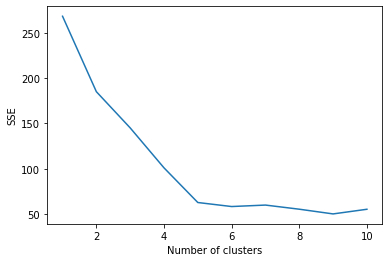

In [21]:
plt.plot(np.arange(1, max_elbow), sse_list)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

# 【主成分分析】

## 主成分分析 : PART1. 前処理

In [22]:
import pandas as pd

data = pd.read_csv("Wholesale customers data.csv")
data

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [23]:
# drop

data_dropped = data.drop(columns = ["Channel", "Region"])
data_dropped

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


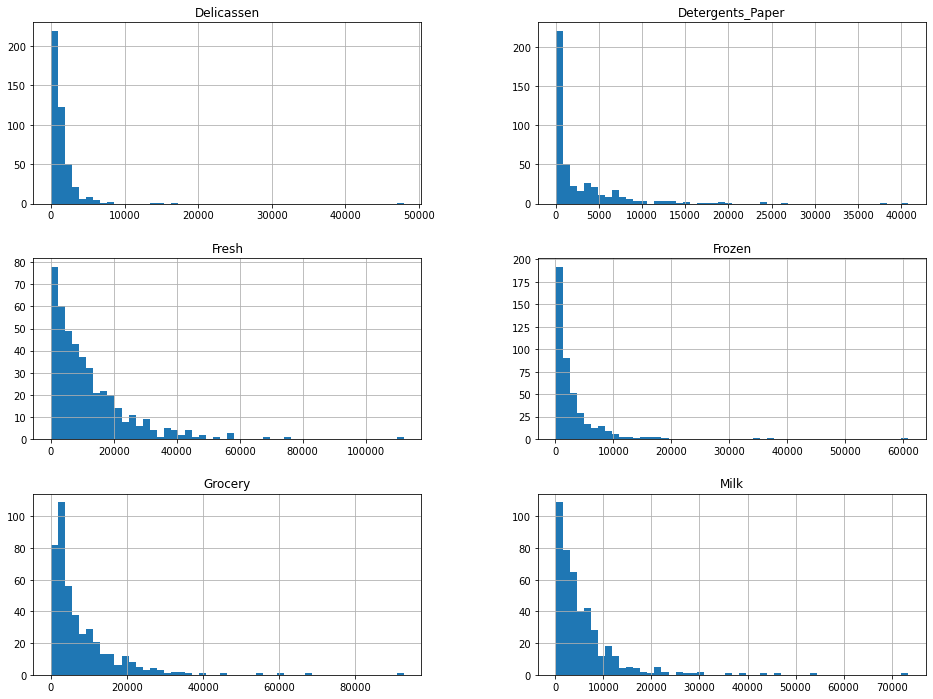

In [24]:
data_dropped.hist(bins=50, figsize=(16, 12))
plt.show()

In [74]:
# 対数変換

from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
data_df = transformer.transform(data_dropped)
data_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678
1,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682
2,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632
3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412
4,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718
...,...,...,...,...,...,...
435,10.299037,9.396986,9.682092,9.483112,5.209486,7.698483
436,10.577172,7.266827,6.639876,8.414274,4.543295,7.760893
437,9.584108,9.647885,10.317053,6.082219,9.605216,7.532624
438,9.239025,7.591862,7.711101,6.946014,5.129899,7.661998


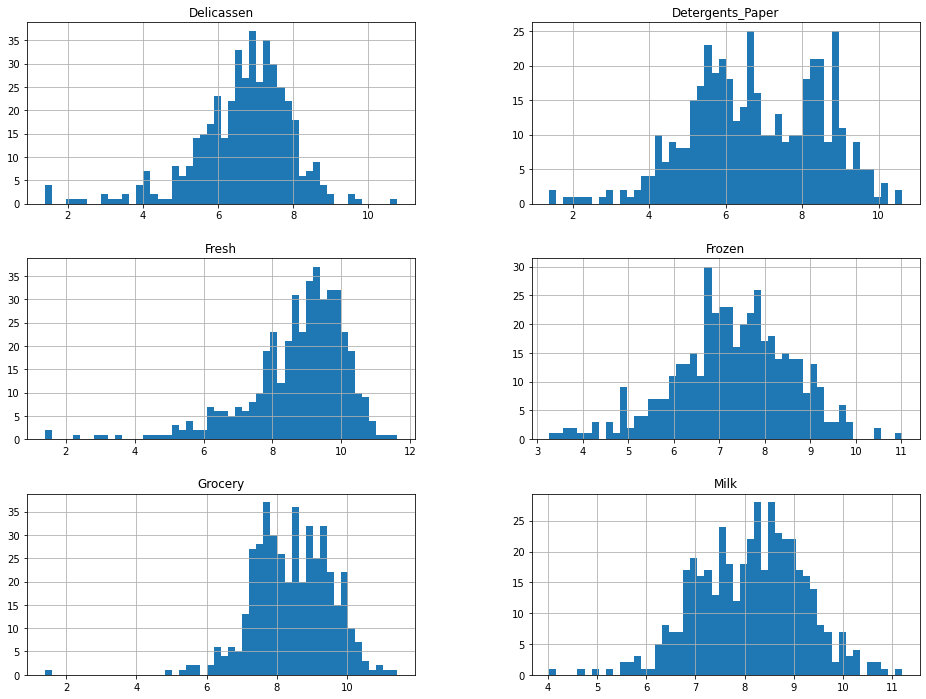

In [26]:
data_df.hist(bins=50, figsize=(16, 12))
plt.show()

## 主成分分析 : PART2. 特徴選択

### 2-1. 散布図行列を見る

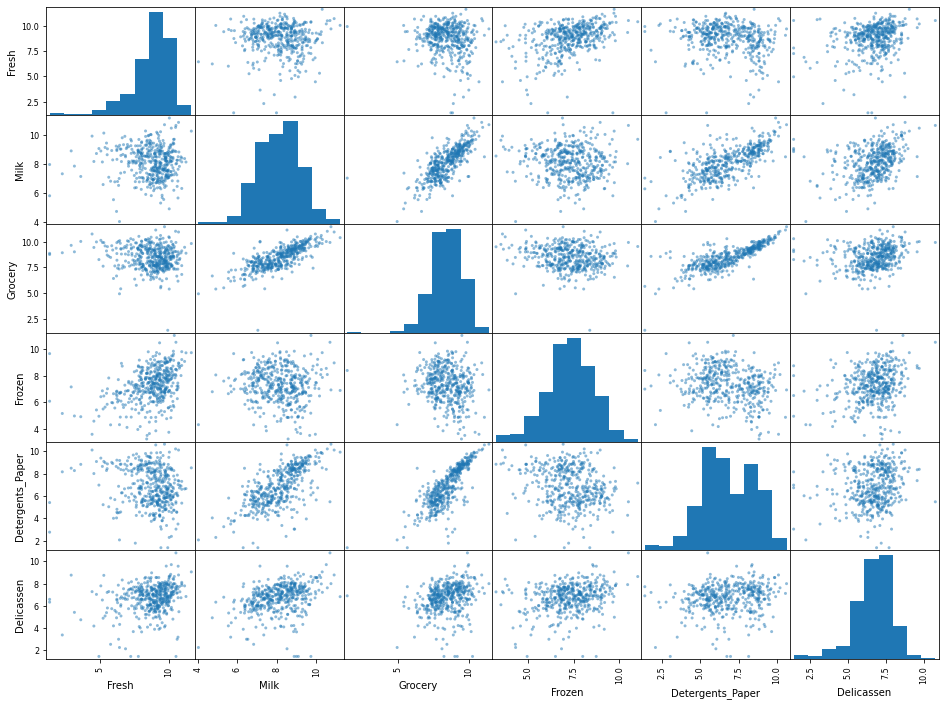

In [27]:
from pandas import plotting

plotting.scatter_matrix(data_df, alpha=0.5, figsize=(16, 12))
plt.show()

* 散布図行列からわかること
  + Milk（牛乳） と Grocery（食料品） に正の相関がありそう
  + Detergents_Paper（衛生用品と紙類） と Grocery（食料品） に正の相関がありそう

### 2-2. 主成分分析で寄与率を見る

[0.44374606 0.72041888 0.83551768 0.93140925 0.97714523 1.        ]


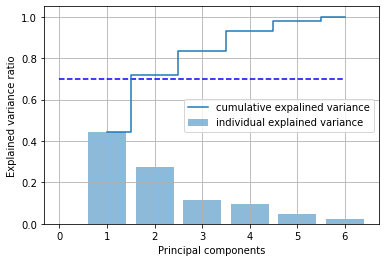

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=6)
pca = pca.fit(data_df)

var_exp = pca.explained_variance_ratio_ # 各主成分の寄与率を算出
cum_var_exp = np.cumsum(var_exp) # cumsumで寄与率を累積

print(cum_var_exp)

plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()

plt.show()

* 寄与率からわかること
  * 第1~2主成分で大体説明できている
  * 第3主成分までで累積寄与率8割

### 2-3. 主成分得点を見る

In [29]:
values = pca.transform(data_df)
values

array([[-1.74690372, -0.06270009, -0.97560649, -1.6869261 ,  0.26756149,
         0.39804008],
       [-1.7935518 , -0.86970685,  0.21270874, -0.00428736,  0.11334319,
         0.23014996],
       [-1.88422616, -1.66935751,  1.29767884, -0.54138152, -0.39048701,
         0.32832955],
       ...,
       [-3.73987651, -0.92890645, -1.02501529, -0.89091009,  0.02868771,
        -0.15093807],
       [ 1.65816416, -0.45713407,  0.5182201 , -1.30372956,  0.11141847,
        -0.0593102 ],
       [ 0.73021579,  3.62818723, -2.00044157, -1.02377432,  0.30366722,
         0.14137736]])

In [30]:
# 見やすく

values_df = pd.DataFrame(data=values,
                                         columns=["主成分{}".format(x+1) for x in range(len(data_df.columns))]
                                         )
values_df

,主成分1,主成分2,主成分3,主成分4,主成分5,主成分6
0,-1.746904,-0.062700,-0.975606,-1.686926,0.267561,0.398040
1,-1.793552,-0.869707,0.212709,-0.004287,0.113343,0.230150
2,-1.884226,-1.669358,1.297679,-0.541382,-0.390487,0.328330
3,1.137087,-1.449765,0.539310,0.435730,-0.680387,-0.662409
4,-0.784600,-2.453600,0.459114,-0.326183,-0.313680,-0.056183
...,...,...,...,...,...,...
435,0.609816,-2.896228,0.615488,0.641506,1.953803,-0.748832
436,3.186783,-1.987871,0.277717,-0.644261,-0.233324,0.452608
437,-3.739877,-0.928906,-1.025015,-0.890910,0.028688,-0.150938
438,1.658164,-0.457134,0.518220,-1.303730,0.111418,-0.059310


### 2-4. 主成分負荷量を見る

In [31]:
eigen_vector = pca.components_
eigen_vector

array([[ 1.75983744e-01, -3.96466809e-01, -4.54773206e-01,
         1.74100737e-01, -7.43475936e-01, -1.48180932e-01],
       [-6.84286737e-01, -1.65903646e-01, -7.28540021e-02,
        -4.92210200e-01, -4.36053085e-02, -5.04725303e-01],
       [-6.80073648e-01,  3.77131200e-02, -2.88501723e-02,
         3.15789011e-01, -2.13920911e-01,  6.24307909e-01],
       [-1.93613372e-01,  1.23413609e-02,  6.29746680e-02,
         7.91332810e-01,  2.01965738e-01, -5.39812902e-01],
       [-6.51579555e-04,  7.21938345e-01,  3.44567764e-01,
        -3.42831477e-02, -5.63260315e-01, -2.04059162e-01],
       [-2.81896156e-02,  5.40851632e-01, -8.15075788e-01,
        -1.76748976e-02,  2.03783246e-01, -2.22778822e-02]])

In [32]:
# 見やすく

pd.DataFrame(eigen_vector,
                      columns = [data_df.columns],
                      index = ["主成分{}".format(x+1) for x in range(len(data_df.columns))],
                      )

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
主成分1,0.175984,-0.396467,-0.454773,0.174101,-0.743476,-0.148181
主成分2,-0.684287,-0.165904,-0.072854,-0.492210,-0.043605,-0.504725
主成分3,-0.680074,0.037713,-0.028850,0.315789,-0.213921,0.624308
主成分4,-0.193613,0.012341,0.062975,0.791333,0.201966,-0.539813
主成分5,-0.000652,0.721938,0.344568,-0.034283,-0.563260,-0.204059
主成分6,-0.028190,0.540852,-0.815076,-0.017675,0.203783,-0.022278


### 2-5. 主成分プロットしてみる

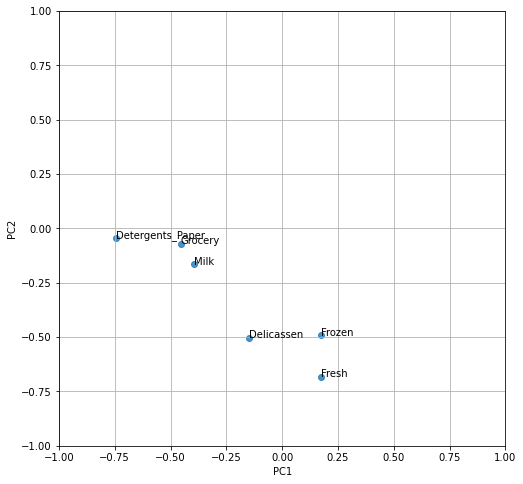

In [33]:
# 第一主成分と第二主成分で張られる平面に、元の特徴量を写像

plt.figure(figsize=(8, 8))

for x, y, name in zip(pca.components_[0], pca.components_[1], data_df.columns[:]):
    plt.text(x, y, name)
    
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

* 第一主成分は「冷凍食品」「生鮮食品」を正に、「衛生用品と紙類」を負に置いた指標
* 第二主成分は「生鮮食品」を負に重視した指標（全てマイナス）
  + これらの指標が何を表しているのかはわからない

## 2-6 次元削減

In [34]:
# 第２主成分まで削減

from sklearn.decomposition import PCA

pca_reduc = PCA(n_components = 2)
pca_reduc = pca_reduc.fit(data_df)
data_pca = pca_reduc.transform(data_df)
data_pca

array([[-1.74690372e+00, -6.27000881e-02],
       [-1.79355180e+00, -8.69706851e-01],
       [-1.88422616e+00, -1.66935751e+00],
       [ 1.13708733e+00, -1.44976512e+00],
       [-7.84599562e-01, -2.45360000e+00],
       [-1.07920027e+00, -3.85981428e-01],
       [-1.12629796e+00,  2.05819654e-01],
       [-1.57375739e+00, -9.63517801e-01],
       [-8.68453007e-01,  6.03547655e-01],
       [-2.88166854e+00, -7.42744638e-01],
       [-2.10697864e+00, -7.53581183e-01],
       [ 9.96966913e-01, -5.52258700e-02],
       [-2.22483754e+00, -1.31883835e+00],
       [-1.89295287e+00, -1.34234174e+00],
       [-2.32546208e+00, -9.76056747e-01],
       [ 4.21626617e-01,  8.24966642e-01],
       [-2.80612506e+00,  1.95568227e+00],
       [ 2.53926925e-01, -5.87484305e-01],
       [-1.39165932e+00, -1.86083076e+00],
       [-1.01042821e+00,  4.17368245e-01],
       [-8.27042055e-01, -1.13768002e+00],
       [ 1.72930510e+00,  1.55354069e-01],
       [-1.37875797e-01, -2.82243155e+00],
       [-2.

## 【問題10】クラスタ数kの選択

In [49]:
# エルボー法を使う

max_elbow = 11
sse_list2 = []

for i in range(1, max_elbow):
    n_clusters = i
    skm2 = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300, tol=50, verbose=False)
    skm2.fit(data_pca)
    sse_list2.append(skm2.min_sse)

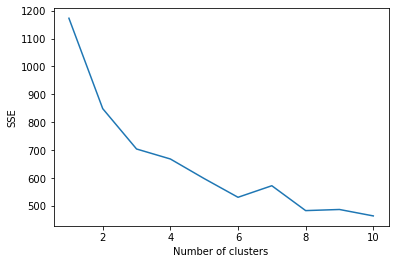

[1172.848576967548,
 848.6469143324398,
 704.0093960699555,
 668.1779979722089,
 597.9332188385101,
 530.8550133571412,
 572.2885025229027,
 483.08798082271267,
 487.10267811780784,
 464.0514141379293]

In [50]:
plt.plot(np.arange(1, max_elbow), sse_list2)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()
sse_list2

* クラスタ数6辺りが適当か

In [51]:
# k-meansを適用

skm3 = ScratchKMeans(n_clusters=6, n_init=10, max_iter=300, tol=50, verbose=False)
skm3.fit(data_pca)

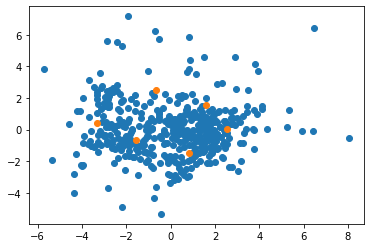

In [52]:
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.scatter(skm3.min_centroids[:, 0], skm3.min_centroids[:, 1])

In [53]:
# 所属クラスタ

y = skm3.predict(data_pca)
y

array([1, 1, 1, 4, 4, 1, 1, 1, 1, 0, 1, 4, 1, 1, 1, 2, 0, 4, 1, 1, 1, 5,
       4, 1, 1, 3, 5, 5, 0, 4, 1, 1, 2, 4, 2, 3, 4, 1, 0, 4, 4, 1, 0, 0,
       3, 0, 0, 1, 1, 0, 4, 3, 1, 3, 4, 1, 0, 0, 5, 1, 3, 0, 1, 1, 4, 0,
       3, 1, 4, 2, 4, 1, 4, 4, 1, 5, 2, 0, 5, 3, 2, 3, 1, 4, 1, 0, 0, 4,
       5, 4, 5, 4, 0, 4, 0, 3, 3, 2, 2, 5, 1, 0, 1, 4, 4, 5, 0, 1, 0, 3,
       5, 1, 4, 4, 5, 5, 2, 4, 4, 5, 5, 2, 5, 1, 4, 4, 4, 1, 3, 4, 5, 2,
       2, 2, 5, 2, 1, 3, 4, 1, 4, 4, 5, 5, 2, 0, 5, 4, 5, 5, 5, 2, 5, 2,
       2, 0, 0, 4, 1, 0, 0, 5, 5, 0, 1, 1, 1, 3, 5, 5, 0, 0, 3, 0, 2, 0,
       4, 5, 5, 4, 1, 1, 3, 4, 3, 5, 2, 3, 1, 0, 5, 5, 2, 3, 2, 4, 4, 1,
       4, 2, 0, 0, 4, 3, 5, 0, 2, 3, 1, 0, 4, 0, 5, 1, 0, 0, 0, 5, 0, 5,
       5, 3, 5, 4, 5, 4, 1, 5, 3, 4, 4, 1, 4, 3, 4, 3, 5, 5, 5, 4, 4, 4,
       4, 1, 1, 0, 5, 5, 4, 4, 2, 0, 4, 4, 1, 5, 2, 4, 4, 4, 2, 5, 5, 1,
       0, 1, 0, 4, 1, 5, 5, 2, 2, 4, 3, 2, 4, 5, 4, 1, 2, 1, 4, 4, 4, 2,
       2, 4, 5, 5, 3, 5, 4, 0, 4, 3, 4, 1, 1, 3, 1,

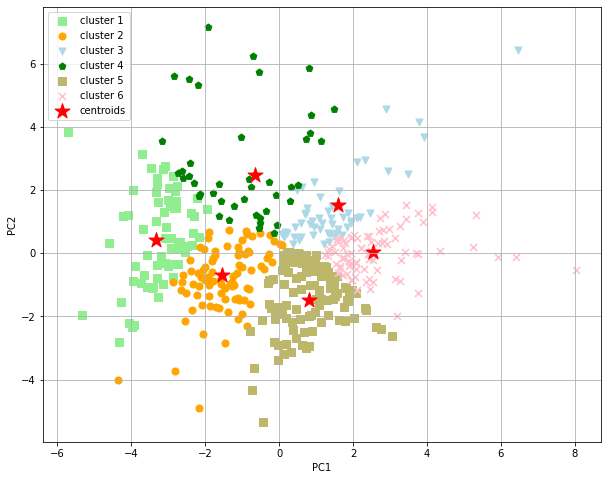

In [54]:
# 見やすく

plt.figure(figsize=(10, 8))

plt.scatter(data_pca[y==0,0],  
                    data_pca[y==0,1], 
                    s=50,
                    c='lightgreen',
                    marker='s',
                    label='cluster 1')
plt.scatter(data_pca[y==1,0],
                    data_pca[y==1,1],
                    s=50,
                    c='orange',
                    marker='o',
                    label='cluster 2')
plt.scatter(data_pca[y==2,0],
                   data_pca[y==2,1],
                    s=50,
                    c='lightblue',
                    marker='v',
                    label='cluster 3')
plt.scatter(data_pca[y==3,0],
                   data_pca[y==3,1],
                    s=50,
                    c='green',
                    marker='p',
                    label='cluster 4')
plt.scatter(data_pca[y==4,0],
                   data_pca[y==4,1],
                    s=50,
                    c='darkkhaki',
                    marker=',',
                    label='cluster 5')
plt.scatter(data_pca[y==5,0],
                   data_pca[y==5,1],
                    s=50,
                    c='pink',
                    marker='x',
                    label='cluster 6')

plt.scatter(skm3.min_centroids[:,0],
                    skm3.min_centroids[:,1],
                    s=250,
                    marker='*',
                    c='red',
                    label='centroids')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid()
plt.show()

* サンプル（各顧客）の分類自体は、第一主成分と第二主成分を使用して、６種のクラスタで上手く分類できている模様

## 【問題11】既知のグループとの比較

* RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

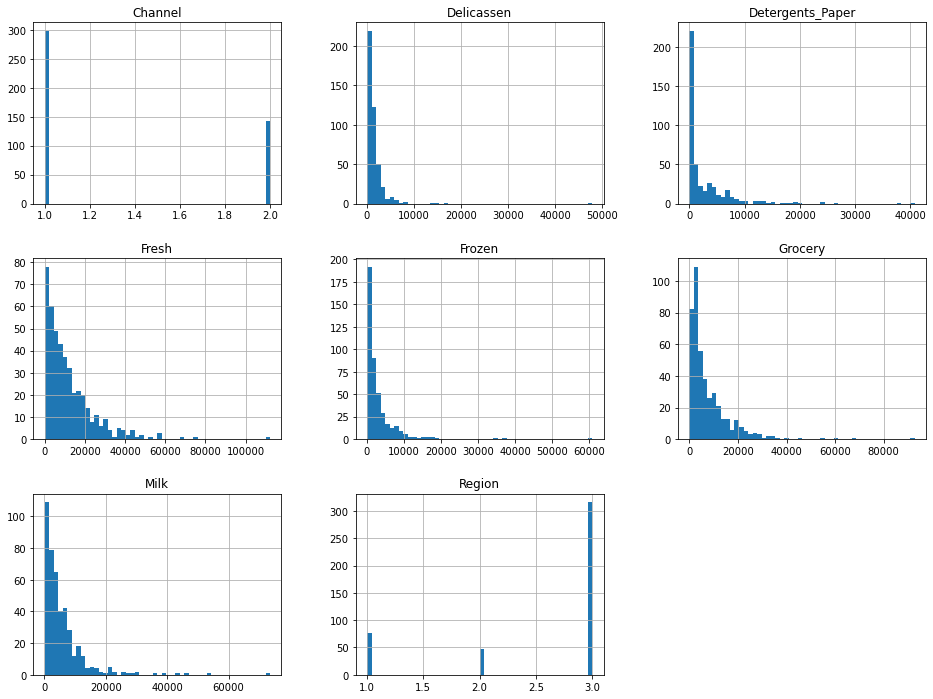

In [55]:
data.hist(bins=50, figsize=(16, 12))
plt.show()

* RegionとChannel は離散値あり、数値自体に意味を持たないカテゴリ変数である

## 【問題12】卸売業者にとって有益な情報

### 12-1. 顧客のクラスタごとの購買傾向確認

In [56]:
data_df["cluster"]=y

In [57]:
data_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678,1
1,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682,1
2,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632,1
3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412,4
4,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718,4
...,...,...,...,...,...,...,...
435,10.299037,9.396986,9.682092,9.483112,5.209486,7.698483,4
436,10.577172,7.266827,6.639876,8.414274,4.543295,7.760893,5
437,9.584108,9.647885,10.317053,6.082219,9.605216,7.532624,0
438,9.239025,7.591862,7.711101,6.946014,5.129899,7.661998,5


In [58]:
data_df["cluster"].value_counts()

4    107
1     88
5     84
0     65
2     53
3     43
Name: cluster, dtype: int64

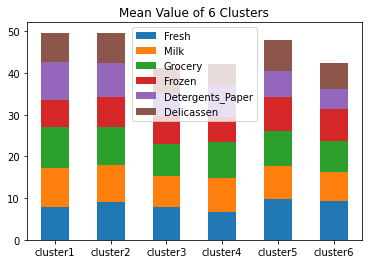

In [61]:
# クラスタ毎の顧客の購買額平均

clusterinfo = pd.DataFrame()
for i in range(6):
    clusterinfo['cluster' + str(i+1)] = data_df[data_df['cluster'] == i].mean()
clusterinfo = clusterinfo.drop('cluster')
    
my_plot = clusterinfo.T.plot(kind='bar', stacked=True, title="Mean Value of 6 Clusters")
my_plot.set_xticklabels(my_plot.xaxis.get_majorticklabels(), rotation=0)


plt.show()

* 購買傾向のばらつきが無い
  + 前処理時に対数変換しない方が良い可能性

### 12-2. 前処理時に対数変換しなかった場合の、顧客のクラスタごとの購買傾向

In [79]:
import pandas as pd

data = pd.read_csv("Wholesale customers data.csv")
data_df = data.drop(columns = ["Channel", "Region"])
data_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


In [80]:
# 次元削減

pca_reduc = PCA(n_components = 2)
pca_reduc = pca_reduc.fit(data_df)
data_pca = pca_reduc.transform(data_df)
data_pca

array([[ 6.50022122e+02,  1.58551909e+03],
       [-4.42680498e+03,  4.04245151e+03],
       [-4.84199871e+03,  2.57876218e+03],
       [ 9.90346437e+02, -6.27980600e+03],
       [ 1.06579987e+04, -2.15972582e+03],
       [-2.76596159e+03, -9.59870727e+02],
       [-7.15550892e+02, -2.01300227e+03],
       [-4.47458367e+03,  1.42949697e+03],
       [-6.71209540e+03, -2.20590916e+03],
       [-4.82363435e+03,  1.34805592e+04],
       [-7.97482898e+03,  5.71121893e+03],
       [ 3.63937790e+01, -6.03789641e+03],
       [ 1.99402021e+04,  4.59128648e+03],
       [ 9.39669558e+03,  5.91315704e+03],
       [ 1.26603704e+04,  4.54194543e+03],
       [-2.99772590e+03, -6.09387930e+03],
       [-1.05895236e+04,  6.58421594e+03],
       [-6.36709518e+03, -3.68071267e+03],
       [ 6.62382534e+03,  1.25471953e+03],
       [-4.86153157e+03, -2.25592266e+02],
       [ 4.79424416e+03, -3.98879936e+03],
       [-7.24486684e+03, -7.34772325e+03],
       [ 1.92992657e+04, -6.93681068e+03],
       [ 1.

In [83]:
skm4 = ScratchKMeans(n_clusters=6, n_init=10, max_iter=300, tol=50, verbose=False)
skm4.fit(data_pca)

In [84]:
# 所属クラスタ

y = skm4.predict(data_pca)
y

array([1, 1, 1, 2, 4, 2, 2, 1, 5, 1, 1, 2, 4, 4, 4, 2, 1, 5, 2, 1, 2, 3,
       4, 0, 4, 2, 2, 2, 0, 4, 2, 5, 4, 4, 5, 1, 4, 1, 1, 4, 4, 2, 1, 0,
       1, 0, 0, 0, 1, 0, 3, 5, 4, 1, 4, 5, 0, 1, 2, 1, 1, 0, 1, 1, 5, 0,
       5, 4, 5, 3, 2, 1, 5, 4, 1, 2, 5, 0, 2, 5, 3, 1, 1, 2, 2, 0, 0, 4,
       3, 4, 2, 2, 0, 2, 1, 5, 5, 5, 5, 2, 1, 1, 1, 4, 2, 2, 1, 1, 1, 0,
       2, 1, 2, 2, 2, 2, 2, 3, 2, 3, 2, 5, 2, 1, 4, 4, 2, 4, 5, 4, 3, 5,
       2, 3, 3, 3, 1, 1, 2, 5, 2, 4, 4, 2, 2, 0, 3, 2, 3, 4, 2, 5, 2, 5,
       5, 0, 1, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 5, 3, 3, 1, 0, 5, 1, 5, 1,
       4, 2, 2, 5, 2, 4, 1, 4, 5, 3, 5, 1, 1, 1, 2, 2, 3, 1, 3, 2, 4, 1,
       2, 2, 0, 0, 4, 5, 5, 0, 3, 1, 5, 0, 2, 0, 3, 1, 1, 1, 0, 2, 1, 3,
       2, 1, 3, 5, 3, 2, 4, 5, 5, 2, 2, 1, 4, 5, 2, 5, 3, 2, 3, 4, 4, 4,
       2, 2, 1, 1, 3, 2, 2, 3, 5, 0, 3, 4, 1, 4, 2, 3, 4, 4, 2, 3, 4, 5,
       1, 0, 1, 4, 1, 2, 3, 5, 1, 4, 5, 5, 4, 2, 2, 2, 5, 2, 4, 4, 4, 4,
       3, 2, 2, 4, 5, 3, 5, 1, 4, 3, 2, 1, 1, 5, 2,

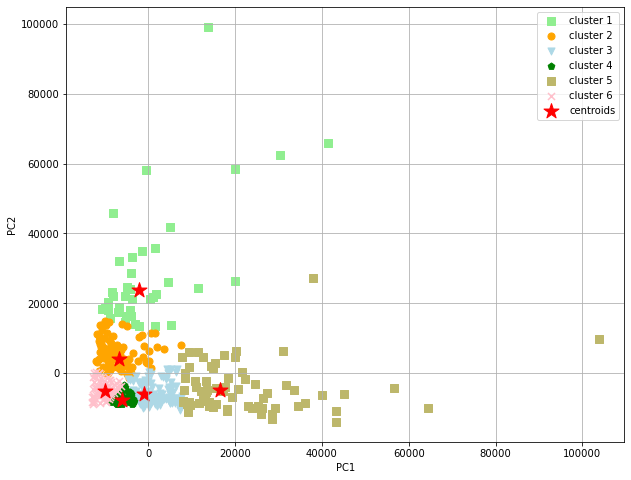

In [87]:
plt.figure(figsize=(10, 8))

plt.scatter(data_pca[y==0,0],  
                    data_pca[y==0,1], 
                    s=50,
                    c='lightgreen',
                    marker='s',
                    label='cluster 1')
plt.scatter(data_pca[y==1,0],
                    data_pca[y==1,1],
                    s=50,
                    c='orange',
                    marker='o',
                    label='cluster 2')
plt.scatter(data_pca[y==2,0],
                   data_pca[y==2,1],
                    s=50,
                    c='lightblue',
                    marker='v',
                    label='cluster 3')
plt.scatter(data_pca[y==3,0],
                   data_pca[y==3,1],
                    s=50,
                    c='green',
                    marker='p',
                    label='cluster 4')
plt.scatter(data_pca[y==4,0],
                   data_pca[y==4,1],
                    s=50,
                    c='darkkhaki',
                    marker=',',
                    label='cluster 5')
plt.scatter(data_pca[y==5,0],
                   data_pca[y==5,1],
                    s=50,
                    c='pink',
                    marker='x',
                    label='cluster 6')

plt.scatter(skm4.min_centroids[:,0],
                    skm4.min_centroids[:,1],
                    s=250,
                    marker='*',
                    c='red',
                    label='centroids')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid()
plt.show()

In [85]:
data_df["cluster"]=y

In [88]:
data_df["cluster"].value_counts()

2    111
1     91
5     75
4     71
3     52
0     40
Name: cluster, dtype: int64

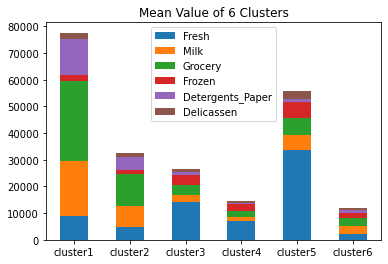

In [86]:
# クラスタ毎の顧客の購買額平均

clusterinfo = pd.DataFrame()
for i in range(6):
    clusterinfo['cluster' + str(i+1)] = data_df[data_df['cluster'] == i].mean()
clusterinfo = clusterinfo.drop('cluster')
    
my_plot = clusterinfo.T.plot(kind='bar', stacked=True, title="Mean Value of 6 Clusters")
my_plot.set_xticklabels(my_plot.xaxis.get_majorticklabels(), rotation=0)


plt.show()

* 散布図では、外れ値の存在で分布は偏っているように見えるがクラスタの分類自体は問題なく行えている
* 積み上げグラフでは、各クラスタに属する顧客の購買傾向を表現できている
  + cluster5に属する顧客は冷凍商品の購買額が高い、など